In [1]:
# Standard libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import lines
import seaborn as sns
import os

In [2]:
# Reading all the files
raw_path = os.getcwd() + '/'
customer = pd.read_csv(raw_path + 'olist_customers_dataset.csv')
geolocation = pd.read_csv(raw_path + 'olist_geolocation_dataset.csv')
orders = pd.read_csv(raw_path + 'olist_orders_dataset.csv')
order_items = pd.read_csv(raw_path + 'olist_order_items_dataset.csv')
order_payments = pd.read_csv(raw_path + 'olist_order_payments_dataset.csv')
order_reviews = pd.read_csv(raw_path + 'olist_order_reviews_dataset.csv')
products = pd.read_csv(raw_path + 'olist_products_dataset.csv')
sellers = pd.read_csv(raw_path + 'olist_sellers_dataset.csv')

# 1 - Visualizações sobre frete - estimativa de entrega 

Abaixo vamos explorar a construção de duas visualizações interessantes no contexto de política de frete. Mais especificamente, são duas visualizações que tratam da expectiva de frete.

## 1-1 Será que vale a pena reduzir a expectativa de entrega e aumentar o percentual de atrasos?

## Primeira Visualização

Será que a estimativa de entrega está sendo bem feita em todos os níveis de estimativa de entrega, ou será que ela pode ser melhor calibrada? Mais especificamente, vamos explorar se as entregas atrasam mais ou menos de acordo com a sua estimativa, ou seja, será que as entregas mais longas acabam tendo mais ou menos atrasos? Será que as etrengas com estimativas mais curtas atrasam mais?

Vamos construir uma visualização então para a distribuição do percentual de atrasos por estimativa de entrega. Algumas alternativas de gráficos a serem explorados:
- boxplot
- boxenplot
- violinplot

In [3]:
orders.head(1)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00


### Criar novas colunas:
- estimativa de entrega: estimativa em dias de em quanto tempo será a antrega do produto
- antecipação/atraso da entrega: data de entrega menos estismativa - um valor positivo indica antecedência

In [4]:
# estimativa de entrega
orders['estimativa_de_entrega'] = pd.to_datetime(orders['order_estimated_delivery_date'])\
- pd.to_datetime(orders['order_purchase_timestamp'])

# antecipação/atraso da entrega
orders['previsao_menos_entrega'] = pd.to_datetime(orders['order_estimated_delivery_date'])\
- pd.to_datetime(orders['order_delivered_customer_date'])

# calcular em dias
orders['previsao_menos_entrega'] = [(x.total_seconds())/(60*60*24) for
                                         x in orders['previsao_menos_entrega']]
orders['estimativa_de_entrega'] = [(x.total_seconds())/(60*60*24) for x 
                                   in orders['estimativa_de_entrega']]

# arredondar
orders['estimativa_de_entrega'] = orders['estimativa_de_entrega'].apply(round)
# orders['previsao_menos_entrega'] = orders['previsao_menos_entrega_days'].apply(round)

In [5]:
orders['estimativa_de_entrega'].value_counts(normalize=True).sort_index().cumsum()\
.round(3).head(20)

2     0.001
3     0.003
4     0.006
5     0.009
6     0.012
7     0.019
8     0.027
9     0.038
10    0.051
11    0.067
12    0.091
13    0.117
14    0.140
15    0.165
16    0.194
17    0.225
18    0.259
19    0.304
20    0.352
21    0.410
Name: estimativa_de_entrega, dtype: float64

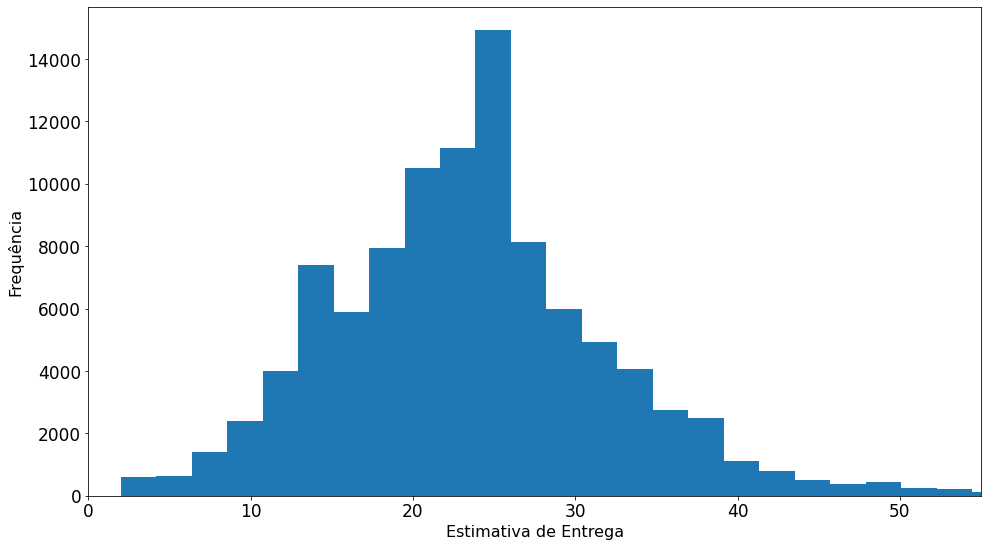

In [6]:
fig = plt.figure(figsize=(16,9))
_ = plt.hist(orders['estimativa_de_entrega'], bins=70)
_ = plt.xlim(0, 55)
_ = plt.ylabel('Frequência', fontsize=16)
_ = plt.xlabel('Estimativa de Entrega', fontsize=16)
_ = plt.yticks(fontsize=17)
_ = plt.xticks(fontsize=17)

_ = plt.savefig('Histograma_Estimativa_Entrega.pdf')

In [7]:
orders['estimativa_de_entrega'].value_counts(normalize=True).sort_index().cumsum()\
.round(3).tail(70)

37     0.942
38     0.950
39     0.957
40     0.964
41     0.969
       ...  
144    1.000
145    1.000
146    1.000
150    1.000
155    1.000
Name: estimativa_de_entrega, Length: 70, dtype: float64

#### Excluir pedidos com entrega maior que 38 dias - não representativo, apenas 5% da base

In [8]:
orders = orders[orders['estimativa_de_entrega']<=38].copy()

### A primeira escolha de visualização que precisamos fazer é escolher com quantos intervalos trabalhar. 

Quanto mais intervalos mais precisão teremos, entretanto, mais díficil fica visualizar o gráfico.

Vamos trabalhos com intervalos pré definidos que sejam interessantes do ponto de vista da análise.

In [9]:
partitions = [0, 7, 11, 14, 18, 21, 24, 28, 32, 38]
intervals = len(partitions)-1

In [10]:
orders['intervalo_estimativa_entrega'] = [x.right for x in pd.cut
                                          (orders['estimativa_de_entrega'],
                                           bins=partitions)]
orders['intervalo_estimativa_entrega']=orders['intervalo_estimativa_entrega'].astype(int)

In [11]:
# Aqui temos o número de observações para cada intervalo
orders['intervalo_estimativa_entrega'].value_counts().sort_index()

7      1914
11     4736
14     7258
18    11884
21    14984
24    16471
28    17750
32    10902
38     8595
Name: intervalo_estimativa_entrega, dtype: int64

Dado que todos intervalos possuem um número bastante alto de exemplos, vamos usar os intervalos pré definidos.

### Vamos seguir com intervalos com distâncias pré fixadas

### Limitação prévia

Uma das limitações dos gráficos a serem explorados é não indicarem quantas observações foram utilizadas para construir cada violin/box.

### Boxplot

A primeira constatação é que os eixos devem ser limitados e os outliers devem ser excluídos.

In [12]:
_ = sns.set_theme()

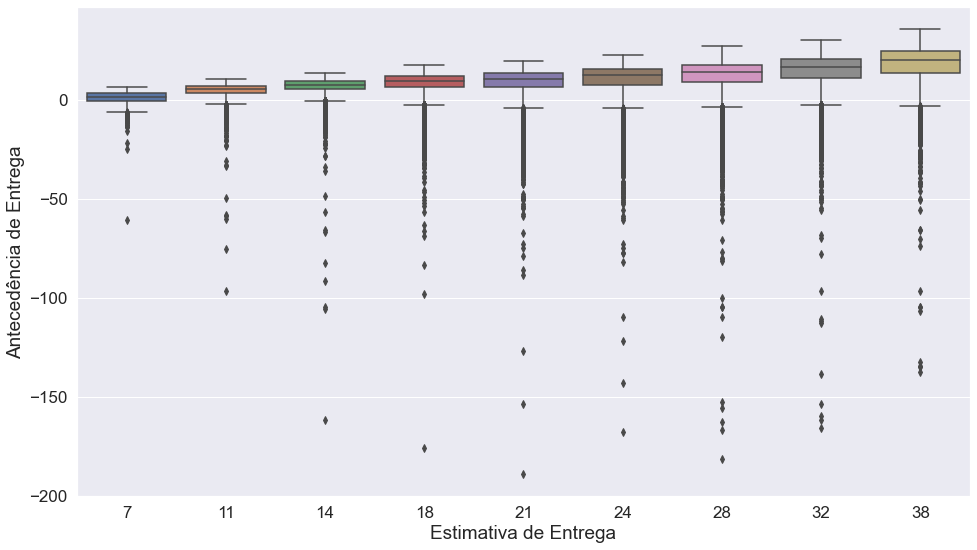

In [13]:
fig = plt.figure(figsize=(16,9))
ax = sns.boxplot(x="intervalo_estimativa_entrega", y="previsao_menos_entrega", 
                data=orders)
_ = plt.ylabel('Antecedência de Entrega', fontsize=19)
_ = plt.xlabel('Estimativa de Entrega', fontsize=19)
_ = plt.yticks(fontsize=17)
_ = plt.xticks(fontsize=17)

_ = plt.savefig('Boxplot_Inicial.pdf')

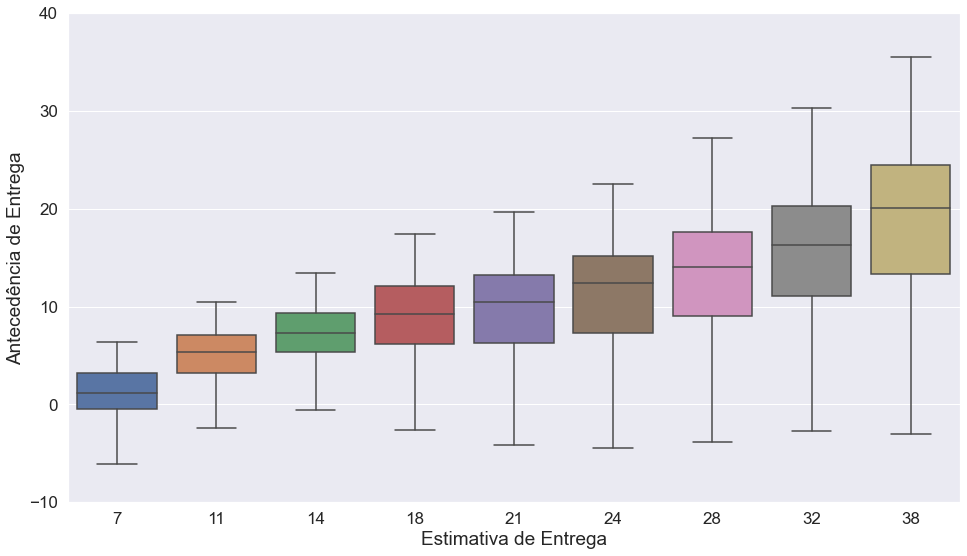

In [14]:
fig = plt.figure(figsize=(16,9))
ax = sns.boxplot(x="intervalo_estimativa_entrega", y="previsao_menos_entrega", 
                data=orders, fliersize=0)
_ = plt.ylim(-10,40)
_ = plt.ylabel('Antecedência de Entrega', fontsize=19)
_ = plt.xlabel('Estimativa de Entrega', fontsize=19)
_ = plt.yticks(fontsize=17)
_ = plt.xticks(fontsize=17)

_ = plt.savefig('Boxplot_1.pdf')

### Violinplot

Já limitando os eixos.

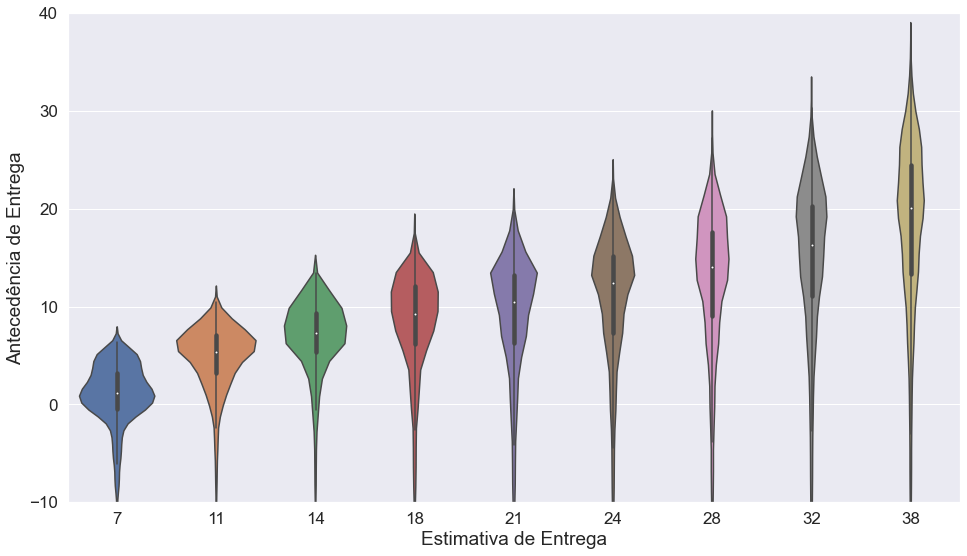

In [15]:
fig = plt.figure(figsize=(16,9))
ax = sns.violinplot(x="intervalo_estimativa_entrega", y="previsao_menos_entrega", 
                data=orders)
_ = plt.ylim(-10,40)
_ = plt.ylabel('Antecedência de Entrega', fontsize=19)
_ = plt.xlabel('Estimativa de Entrega', fontsize=19)
_ = plt.yticks(fontsize=17)
_ = plt.xticks(fontsize=17)

_ = plt.savefig('Violinplot_1.pdf')

## Conclusão sobre o Violinplot e Boxplot

### O que o gráficos dizem

Os dois gráficos dizem que quanto maior a estimativa de entrega maior é a antecedência com que a entrega é feita. Além disso, observa-se que as distribuições se alargam conforme aumenta a estimativa.


### Limitações das visualizações

Ainda que ambos os gráficos permitam visualizar a relação entre estimativa e entrega, falham em indicar o percentual de entregas que possui atraso, aspecto bastante importante da visualização. 

Isso porque o boxplot traça apenas os quartis, não indicando qual o percentual de atraso, apenas que ele está entre 25% e 0%.

No caso do violinplot, quando limitamos o eixo, peredemos a referência de quantos pontos temos para baixo.

Existe também a limitação de quantas observações se tratam cada box/violin.

### Solução proposta
- Boxenplot
- Adicionar em cima o percentual de entregas que teve atraso

## Soluções propostas 1

### Boxenplot

O Boxenplot, por outro lado, consegue dar uma ideia de qual percentual de pedidos está abaixo da linha do zero, indicando quantos tiveram atraso. No entanto, adiciona mais complexidade e exige mais conhecimento prévio de quem interpreta o gráfico.

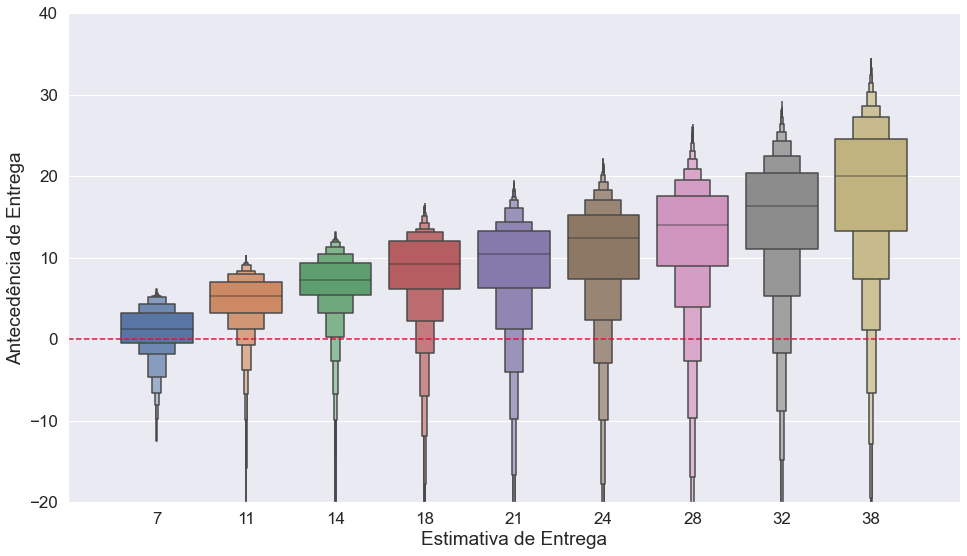

In [16]:
fig = plt.figure(figsize=(16,9))
ax = sns.boxenplot(x="intervalo_estimativa_entrega", y="previsao_menos_entrega", 
                data=orders, showfliers=False)
_ = plt.hlines(0,-1, intervals, colors='crimson', linestyles='dashed')
_ = plt.ylim(-20,40)
_ = plt.xlim(-1, intervals)
_ = plt.ylabel('Antecedência de Entrega', fontsize=19)
_ = plt.xlabel('Estimativa de Entrega', fontsize=19)
_ = plt.yticks(fontsize=17)
_ = plt.xticks(fontsize=17)

_ = plt.savefig('Boxenplot_1.pdf')

### Conclusão Boxenplot

Ao adicionar muitas linhas marcando os quantis, o boxenplot adiciona bastante complexidade na visualização. Poderíams reduzir essas linhas, marcando menos percentuais, como 75%, 90% e 95%, mas de qualquer forma teríamos apenas uma estimativa dos atrasos (entre quais linhas ele caiu). Portanto, vamos descartar essa solução.

### Adicionar um label em cima dos boxs/violins

Outra forma de adicionar nas visualizações o percentual de atraso é adicionando um label indicando que percentual está abaixo do zero (o que indica atraso).

#### Qual percentual de entregas atrasa em cada intervalo?

Observar o percentual e distribuição dos atrasos para cada intervalo. 

In [17]:
# em cada intervalo, quantos valores são negativos?
# Qual a distribuição dos atrasos
delays_pct = {}
delays_distribution = {}
for interval in orders['intervalo_estimativa_entrega'].unique():
    # delays percentage
    delay = len(orders[(orders['intervalo_estimativa_entrega']==interval) &\
                       (orders['previsao_menos_entrega']<0)])
    total = len(orders[orders['intervalo_estimativa_entrega']==interval])
    delays_pct[interval] = delay/total*100
    # distribuition
    distribution = orders.loc[(orders['intervalo_estimativa_entrega']==interval) &\
                       (orders['previsao_menos_entrega']<0), 'previsao_menos_entrega']
    delays_distribution[interval] = distribution
    
delays_pct = pd.Series(delays_pct).sort_index()
delays_distribution = pd.Series(delays_distribution).sort_index()


### Boxplot com labels

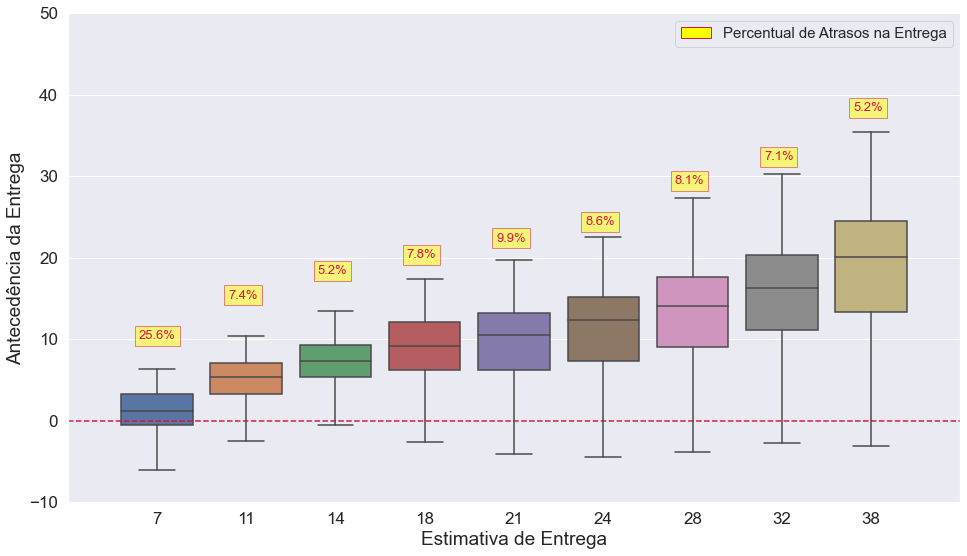

In [18]:
fig = plt.figure(figsize=(16,9))
ax = sns.boxplot(x="intervalo_estimativa_entrega", y="previsao_menos_entrega", 
                data=orders, fliersize=0)

_ = plt.ylim(-10,50)
_ = plt.xlim(-1, intervals)
_ = plt.hlines(0,-1, intervals, colors='crimson', linestyles='dashed')
_ = plt.xlabel('Estimativa de Entrega', fontsize=19)
_ = plt.ylabel('Antecedência da Entrega', fontsize=19)
_ = plt.yticks(fontsize=17)
_ = plt.xticks(fontsize=17)

import matplotlib.patches as mpatches
red_patch = mpatches.Patch(facecolor='yellow', label='Percentual de Atrasos na Entrega', edgecolor='crimson')
plt.legend(handles=[red_patch], fontsize=15)

# Dusa opções, colocando em cima ou de acordo com o próprio valor
text_y = [10, 15, 18, 20, 22, 24, 29, 32, 38 ,27, 29, 31, 35, 38, 40]
# text_y = delays_pct*2.8
for i in range(intervals):
    _ = plt.text(x = i-.2, y=text_y[i], 
                 s=str(round(delays_pct.iloc[i],1))+'%', fontsize=13, color='crimson',
                 bbox=dict(facecolor='yellow',alpha=0.5, edgecolor='crimson'))
    
_ = plt.savefig('Boxplot_2.pdf')

### Violin plot com labels

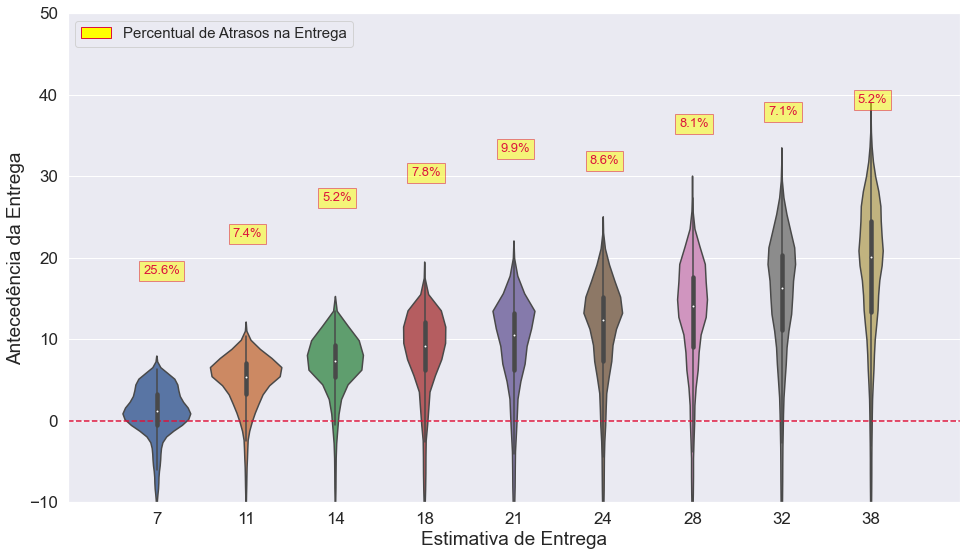

In [19]:
fig = plt.figure(figsize=(16,9))
ax = sns.violinplot(x="intervalo_estimativa_entrega", y="previsao_menos_entrega", 
                data=orders)
_ = sns.set_theme()

_ = plt.ylim(-10,50)
_ = plt.xlim(-1, intervals)
_ = plt.hlines(0,-1, intervals, colors='crimson', linestyles='dashed')
_ = plt.xlabel('Estimativa de Entrega', fontsize=19)
_ = plt.ylabel('Antecedência da Entrega', fontsize=19)
_ = plt.yticks(fontsize=17)
_ = plt.xticks(fontsize=17)

import matplotlib.patches as mpatches
red_patch = mpatches.Patch(facecolor='yellow', label='Percentual de Atrasos na Entrega',
                           edgecolor='crimson')
plt.legend(handles=[red_patch], fontsize=15, loc=2)

# Dusa opções, colocando em cima ou de acordo com o próprio valor
text_y = np.array([12, 15, 18, 20, 22, 21, 24, 25, 26,27, 29, 31, 35, 38, 40])*1.5
# text_y = delays_pct*3
for i in range(intervals):
    _ = plt.text(x = i-.15, y=text_y[i], 
                 s=str(round(delays_pct.iloc[i],1))+'%', fontsize=13, color='crimson',
                 bbox=dict(facecolor='yellow',alpha=0.5, edgecolor='crimson'))

_ = plt.savefig('Violin_2.pdf')

Essa visualização ilustra mais precisamente a distribuição das entregas em relação à estimativa de entrega. 

A melhor alternativa parece ser o violin plot: mais simples em relação ao boxplot e boxenplot, por não precisar de linhas marcandos os quantis. Permite melhor visualizar as distribuições também. De fato, não estamos interessados nos quantis propriamente, mas sim na distribuição geral (na sua concentração, que é melhor ilutrada pelo violin) e no percentual que teve atraso. Portanto, o boxplot acaba adicionando mais complexidade desncessariamente.



#### Dificuldades:
- O problema dessa visualização está no fato que a posição da legenda vai sempre subindo mas o valor da legenda em muitos casos diminui.


- Outro problema é que apesar de estarem espaçados igualmente, os intervalos são diferentes.


- também é difícil comparar rapidamente quem possui as médias mais altas nos violinpolots do centro.

## Soluções propostas 2

Em relação ao primeiro problema, duas propostas de solução foram examinanadas. Uma foi o uso de um segundo eixo, a outra variar a altura dos labels segundo seu valor. Seguem as soluções abaixo:

### Primeira opção

Variar altura dos labels segundo valor na parte inferior do eixo y

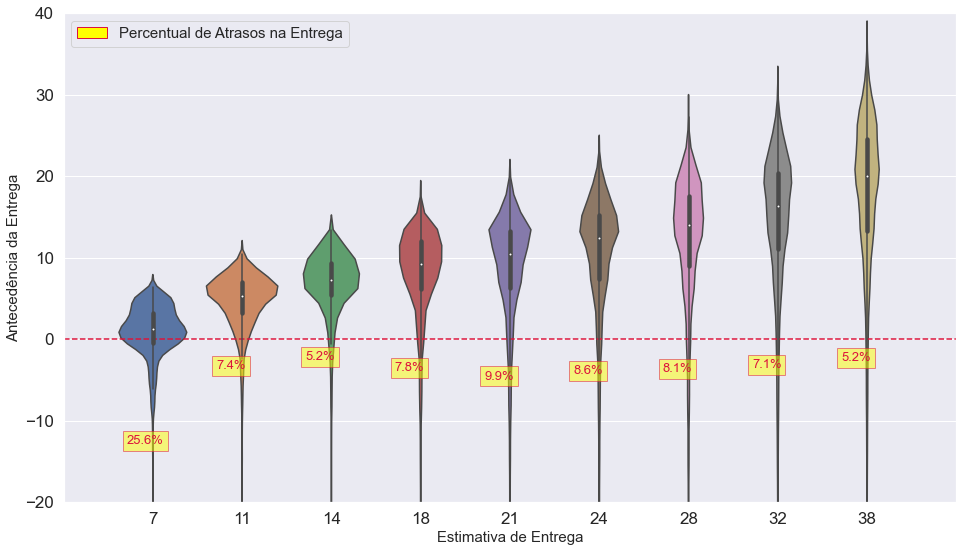

In [20]:
fig = plt.figure(figsize=(16,9))
ax = sns.violinplot(x="intervalo_estimativa_entrega", y="previsao_menos_entrega", 
                data=orders)
_ = sns.set_theme()
_ = plt.ylim(-20,40)
_ = plt.xlim(-1, intervals)
_ = plt.hlines(0,-1, intervals, colors='crimson', linestyles='dashed')
_ = plt.xlabel('Estimativa de Entrega', fontsize=15)
_ = plt.ylabel('Antecedência da Entrega', fontsize=15)
_ = plt.yticks(fontsize=17)
_ = plt.xticks(fontsize=17)

red_patch = mpatches.Patch(facecolor='yellow', label='Percentual de Atrasos na Entrega',
                           edgecolor='crimson')
plt.legend(handles=[red_patch], fontsize=15, loc=2)

text_y = delays_pct*-.5
for i in range(intervals):
    _ = plt.text(x = i-.29, y=text_y.iloc[i], 
                 s=str(round(delays_pct.iloc[i],1))+'%', fontsize=13, color='crimson',
                 bbox=dict(facecolor='yellow',alpha=0.5, edgecolor='crimson'))
    
_ = plt.savefig('Violinplot_4.pdf')

### Segunda opcão

Um segundo eixo y que indique o percentual de entregas com atraso.

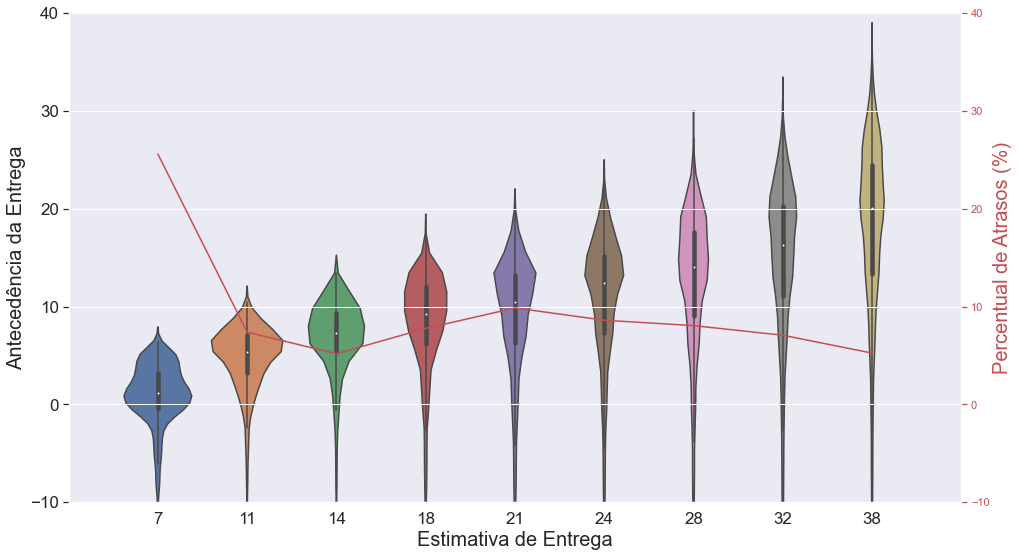

In [21]:
# sns.reset_orig()
sns.set_theme()
title_size=20
fig = plt.figure(figsize=(16,9))
ax = sns.violinplot(x="intervalo_estimativa_entrega", y="previsao_menos_entrega", 
                data=orders)
# sns.axes_style("darkgrid")
_ = plt.ylim(-10,40)
_ = plt.xlim(-1, intervals)
# _ = plt.hlines(0,-1, intervals, colors='crimson', linestyles='dashed')
_ = plt.xlabel('Estimativa de Entrega', fontsize=title_size)
_ = plt.ylabel('Antecedência da Entrega', fontsize=title_size)
_ = plt.yticks(fontsize=17)
_ = plt.xticks(fontsize=17)
    
second_color = 'r'
ax2 = ax.twinx()
_ = ax2.set_ylim(-10, 40)
ax2.tick_params(axis='y', colors=second_color)
_ = ax2.tick_params(axis='y', color=second_color)
_ = ax2.set_ylabel('Percentual de Atrasos (%)', fontsize=title_size, color=second_color)
_ = sns.lineplot(x=range(intervals), y=delays_pct, color=second_color, ax=ax2)
# plt.plot(range(15), text_y, ax=ax2, legend=False, color="r")

_ = plt.savefig('Violinplot_5.pdf')

## Conclusão

O gráfico mais adequado para atingir o objetivo de visualizar o comportamento da distribuição das antecendências/ atrasos, adicionando a dimensão de qual o percentual de atrasos, é o do boxplot com os labels abaixo.

A partir dele, é possível reconhecer como estimativas de entrega menores geram um percentual de atrasos maiores. Isso, portanto, é um fato a ser ponderado do ponto de vista estratégico da empresa. Será que vale a pena prometer uma entrega mais rápida gerando um número maior de atrasos, ao induzir um a compra? Ou será que os atrasos acabam gerando reviews negativos que acabam prejudicando a recorrência da compra? 

# Segunda Visualização
## Visualizar distribuições das entregas em que houveram atrasos

Interessante seria ver a distribuição de um percentual dos atrasos, como 95%. Ou seja, qual o máximo de tempo (com 95% de confiança) que um atraso pode ter? Seria interessante ter também linhas verticais marcando os quantis (50%, 25%).

- Uma opção é fazer o histograma de cada um dos grupos de estimativa.
- Fazer um boxplot
- Fazer um boxenplot - https://vita.had.co.nz/papers/letter-value-plot.pdf
- http://datavizcatalogue.com/blog/box-plot-variations/

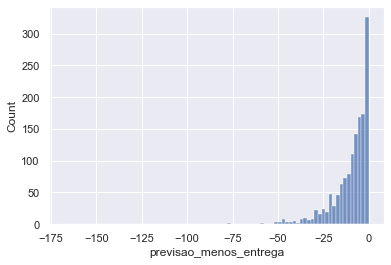

In [22]:
# fig = plt.figure(figsize=(16,9))
_ = sns.histplot(x=delays_distribution.iloc[5])

In [23]:
orders['entrega_com_atraso'] = np.where(orders['previsao_menos_entrega']<0, 
                                        orders['previsao_menos_entrega']*-1, np.nan)

In [24]:
means = []
for inter in sorted(orders['intervalo_estimativa_entrega'].unique()):
    means.append(orders.loc[orders['intervalo_estimativa_entrega']==inter,
                            'entrega_com_atraso'].mean())

## Boxplot

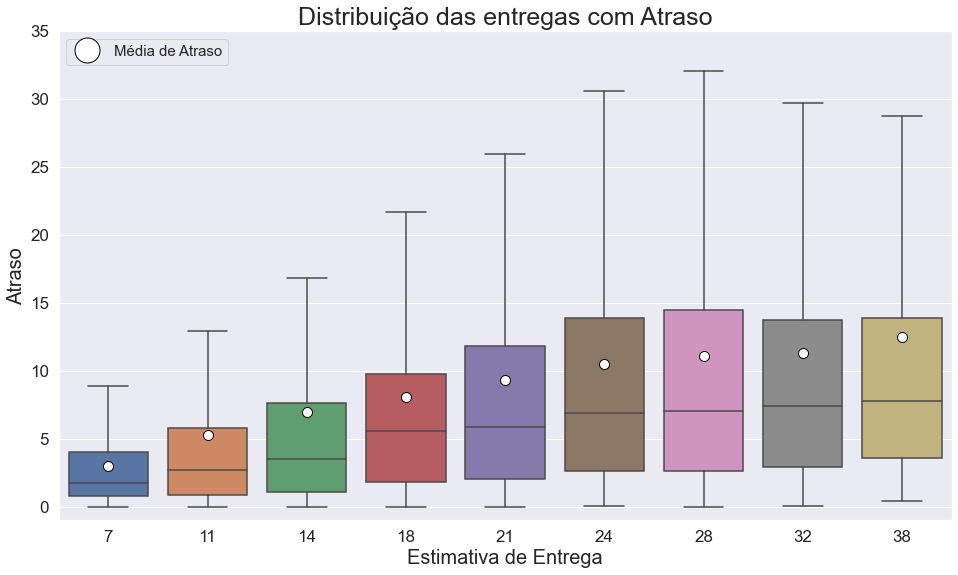

In [25]:
fig = plt.figure(figsize=(16,9))
title_size=20
_ = sns.set_theme()
_ = sns.boxplot(x='intervalo_estimativa_entrega', y='entrega_com_atraso', data=orders,
                  showfliers=False, showmeans=True, meanprops={"marker":"o", "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"})

_ = plt.ylim(-1, 35)
_ = plt.xlabel('Estimativa de Entrega', fontsize=title_size)
_ = plt.ylabel('Atraso', fontsize=title_size)
_ = plt.title('Distribuição das entregas com Atraso', fontsize=25)
_ = plt.yticks(fontsize=17)
_ = plt.xticks(fontsize=17)

line1 = lines.Line2D(range(1), range(1), color="black",
               marker='o', markerfacecolor="white", linestyle='none', markersize=25)
_ = plt.legend([line1],['Média de Atraso'],numpoints=1, loc=2, fontsize=15)

_ = plt.savefig('Boxplot_Atraso.pdf')

## Boxenplot

Talvez fosse interessante adicionar alguma espécie de legenda marcando qual o percentual que a linha corta.
Adicionar legenda explicando a bola branca.

In [26]:
perc_75_ = []
for inter in sorted(orders['intervalo_estimativa_entrega'].unique()):
    perc_75_.append(orders.loc[orders['intervalo_estimativa_entrega']==inter,
                            'entrega_com_atraso'].quantile(q=.75))
    
perc_93_ = []
for inter in sorted(orders['intervalo_estimativa_entrega'].unique()):
    perc_93_.append(orders.loc[orders['intervalo_estimativa_entrega']==inter,
                            'entrega_com_atraso'].quantile(q=.935))

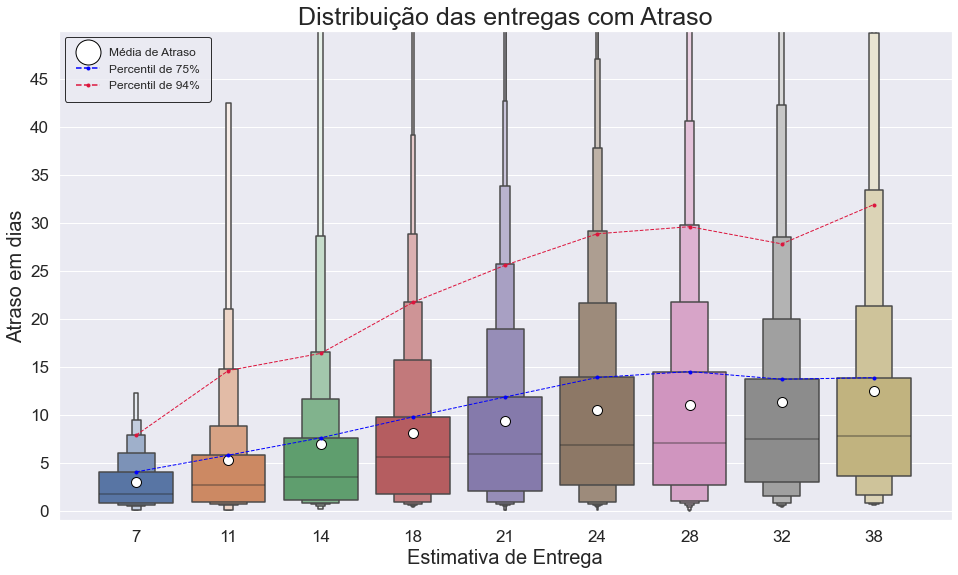

In [27]:
fig = plt.figure(figsize=(16,9))
title_size=20
_ = sns.set_theme()
_ = sns.boxenplot(x='intervalo_estimativa_entrega', y='entrega_com_atraso', data=orders,
                  showfliers=False)
_ = plt.plot(means, 'o', color='black', mec="black", 
                       mfc="white", markersize=10)

_ = plt.yticks(np.arange(0, 50, 5))
_ = plt.yticks(fontsize=17)
_ = plt.xticks(fontsize=17)
_ = plt.ylim(-1, 50)
_ = plt.xlabel('Estimativa de Entrega', fontsize=title_size)
_ = plt.ylabel('Atraso em dias', fontsize=title_size)
_ = plt.title('Distribuição das entregas com Atraso', fontsize=25)

line1 = lines.Line2D(range(1), range(1), color="black",
               marker='o', markerfacecolor="white", linestyle='none', markersize=25)

line2 = lines.Line2D(range(1), range(1), color="blue",
               marker='.', linestyle='--')

line3 = lines.Line2D(range(1), range(1), color="crimson",
               marker='.', linestyle='--')

_ = plt.legend([line1, line2, line3],['Média de Atraso', 'Percentil de 75%', 
                                      'Percentil de 94%'],numpoints=1, 
               loc=2, fontsize=12, 
               edgecolor='black', borderpad=.9)

_ = plt.plot(perc_75_, '--', color='blue',  linewidth=1, marker='.')
_ = plt.plot(perc_93_, '--', color='crimson', linewidth=1, marker='.')

_ = plt.savefig('Boxenplot_Atraso.pdf')

## Conclusão

O boxenplot nesse caso permite examinarmos mais quantis da distribuição dos atrasos, dando portanto mais informação. De fato, podemos a partir da visualização ver em faixas qual a probabilidade de, dado o atraso, atrasar mais de X dias, ou então que quantidade de dias inclui 95% dos atrasos. Por outro lado, adiciona mais complexidade na visualização, e exige que o leitor domine conceitos de distribuição e estatística.